# 1. Import Dependencies and Setup

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
import imghdr
from matplotlib import pyplot as plt
from tensorflow.keras import models, layers, metrics

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

Num GPUs Available:  1


# 2. Preprocess Data

In [3]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']
for image_class in os.listdir(os.path.join('data')):
    for image in os.listdir(os.path.join('data', image_class)):
        image_path = os.path.join('data', image_class, image)
        try:
            img = cv2.imread(image_path)
            typ = imghdr.what(image_path)
            if typ not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            print(e)
            # os.remove(image_path)
print('Complete!')

Image not in ext list data\salad\022223-greek-salad-lede.jpg
Image not in ext list data\salad\0328-ceasar-salad-lede.jpg
Image not in ext list data\salad\1382542290621.webp
Image not in ext list data\salad\1383814482359.webp
Image not in ext list data\salad\51115620_fattoush_1x1.jpg
Image not in ext list data\salad\arabic-fattoush-salad-scaled.webp
Image not in ext list data\salad\Best-Ever-Greek-Salad-2.jpg
Image not in ext list data\salad\best-simple-green-salad-1-2.jpg
Image not in ext list data\salad\caesar-salad-1-12.jpg
Image not in ext list data\salad\CaesarSalad_RECIPE_041223_51228.jpg
Image not in ext list data\salad\Chicken-Caesar-Salad-Pizza-1-scaled.jpg
Image not in ext list data\salad\chicken-caesar-salad-recipe-snippet.jpg
Image not in ext list data\salad\EP-03132015-passover-salad-6x4.jpg
Image not in ext list data\salad\fattoush-salad-1-11.jpg
Image not in ext list data\salad\fattoush-salad-recipe-050718.jpg
Image not in ext list data\salad\Fattoush-Salad-with-hands-sca

# 3. Load and Scale Data

Found 2424 files belonging to 5 classes.


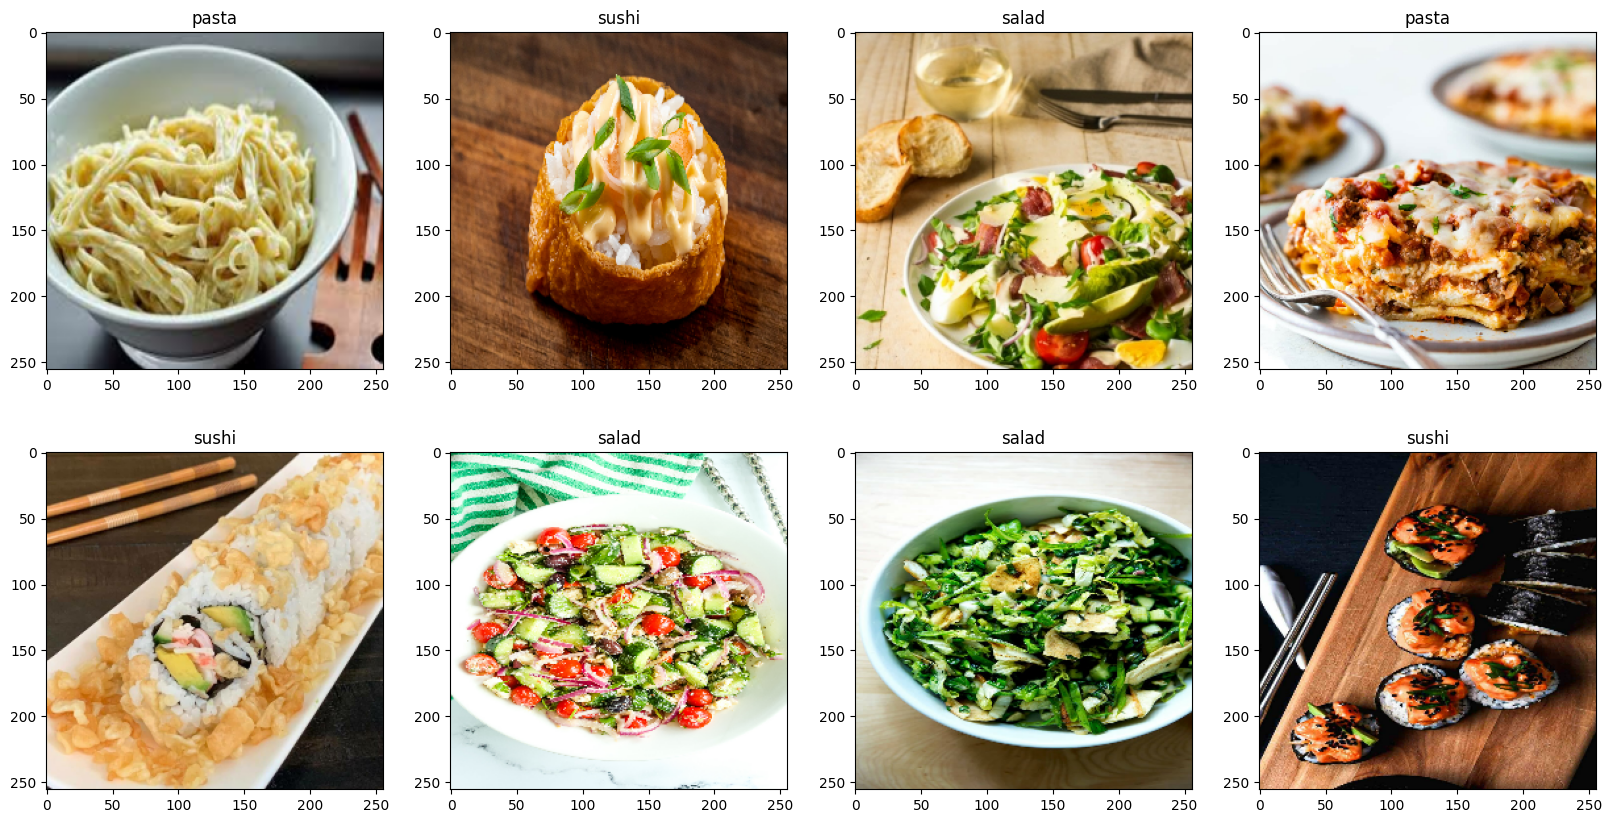

In [4]:
data = tf.keras.utils.image_dataset_from_directory('data', seed=1)
iter = data.as_numpy_iterator()
# batch object has the image at batch[0] in numpy RGB array form, and the corresponding label at batch[1]
batch = iter.next()
labels =  os.listdir('data')

# visualization
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(20,10))
for i, img in enumerate(batch[0][:8]):
    ax[i//4][i%4].imshow(img.astype(int))
    ax[i//4][i%4].title.set_text(labels[batch[1][i]])
plt.show()

# scale each RGB value to [0,1]
data = data.map(lambda x,y: (x/255, y))

# 4. Split Data

In [5]:
batch_size = len(data)
train_size = int(batch_size *.7)
val_size = int(batch_size *.2)
test_size = int(batch_size *.1)
while(train_size + val_size + test_size != batch_size):
    test_size += 1
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 5. Train Model

In [56]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), 1, activation='relu', input_shape=(256,256,3), padding='same'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(128, (3, 3), 1, activation='relu'))
model.add(layers.Conv2D(128, (1, 1), 1, activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(256, (3, 3), 1, activation='relu'))
model.add(layers.Conv2D(256, (1, 1), 1, activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(len(labels), activation='softmax'))

In [57]:
model.compile('adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 126, 126, 256)     73984     
                                                                 
 conv2d_35 (Conv2D)          (None, 126, 126, 256)     65792     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 63, 63, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 61, 61, 512)      

In [63]:
cb = tf.keras.callbacks.TensorBoard(log_dir='logs')
hist = model.fit(train, epochs=2, validation_data=val, callbacks=cb)

Epoch 1/2
53/53 [==============================] - 14s 253ms/step - loss: 0.1268 - accuracy: 0.9617 - val_loss: 0.8543 - val_accuracy: 0.8083
Epoch 2/2
53/53 [==============================] - 14s 257ms/step - loss: 0.0767 - accuracy: 0.9782 - val_loss: 0.9523 - val_accuracy: 0.8333


In [20]:
# model.save(os.path.join('models', 'model.h5'))

# 6. Testing

1/1 [==============================] - 0s 58ms/step
Accuracy is : 0.7943548387096774


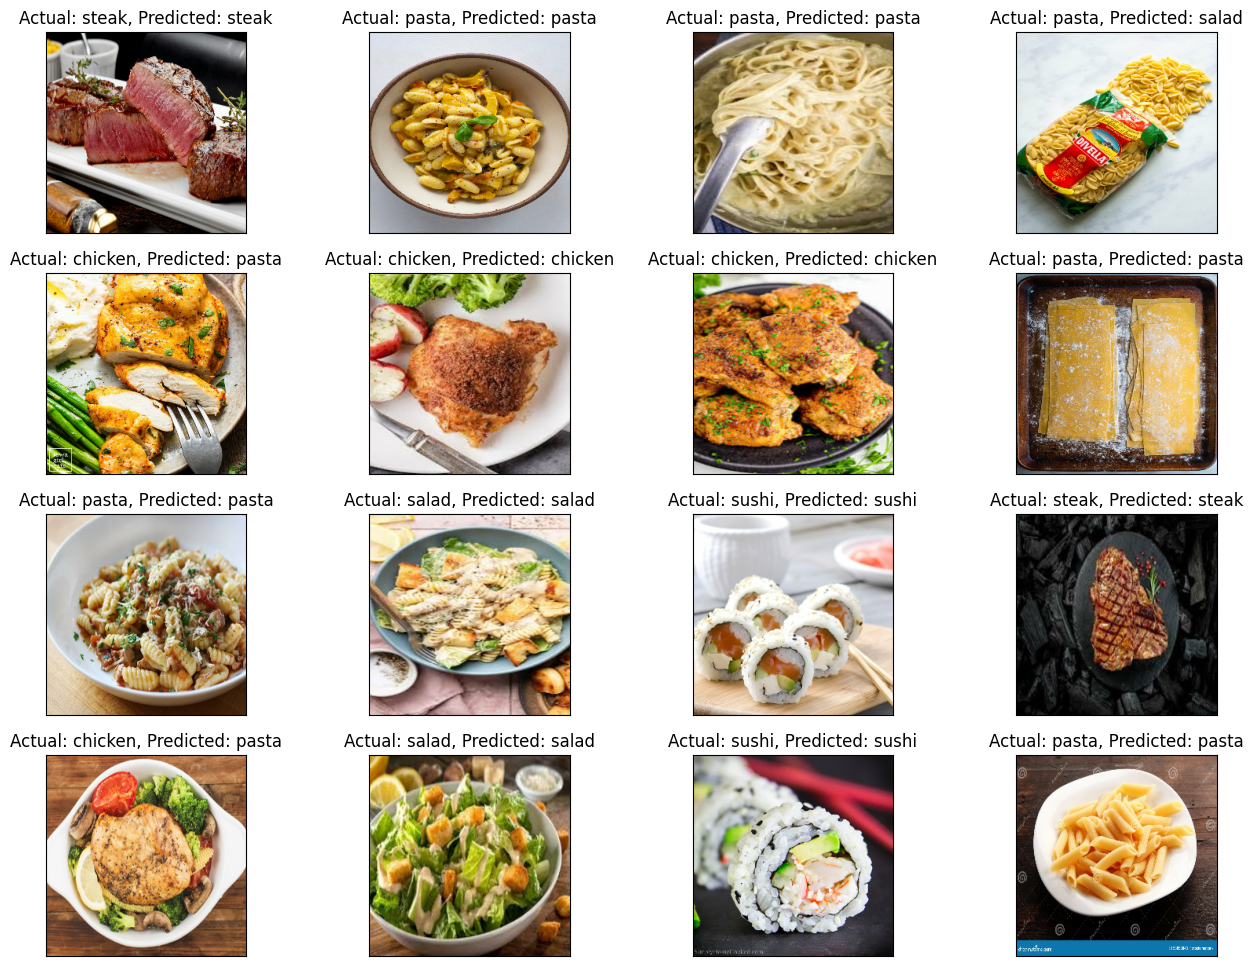

In [69]:
model = models.load_model(os.path.join('models', 'model.h5'))

fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(16,12))

df = pd.DataFrame()
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    for i in range(16):
        ax[i//4][i%4].imshow(X[i])
        ax[i//4][i%4].title.set_text('Actual: ' + labels[y[i]] + ', Predicted: ' + labels[np.argmax(yhat[i])])
        ax[i//4][i%4].get_xaxis().set_ticks([])
        ax[i//4][i%4].get_yaxis().set_ticks([])
    
    temp = pd.DataFrame({'actual' : y.tolist(), 'prediction' : yhat.tolist()})
    temp['prediction'] = temp['prediction'].apply(np.argmax)
    
    df = pd.concat([df, temp], axis=0)
true_count = df[df.actual == df.prediction].shape[0]
acc = true_count / df.shape[0]
print('Accuracy is :', acc)